In [7]:
#!pip install tensorflow
#!pip install matplotlib

In [92]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [117]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [59]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [61]:
class_names = dataset.class_names
class_names
n_classes = len(class_names)

In [62]:
len(dataset)

68

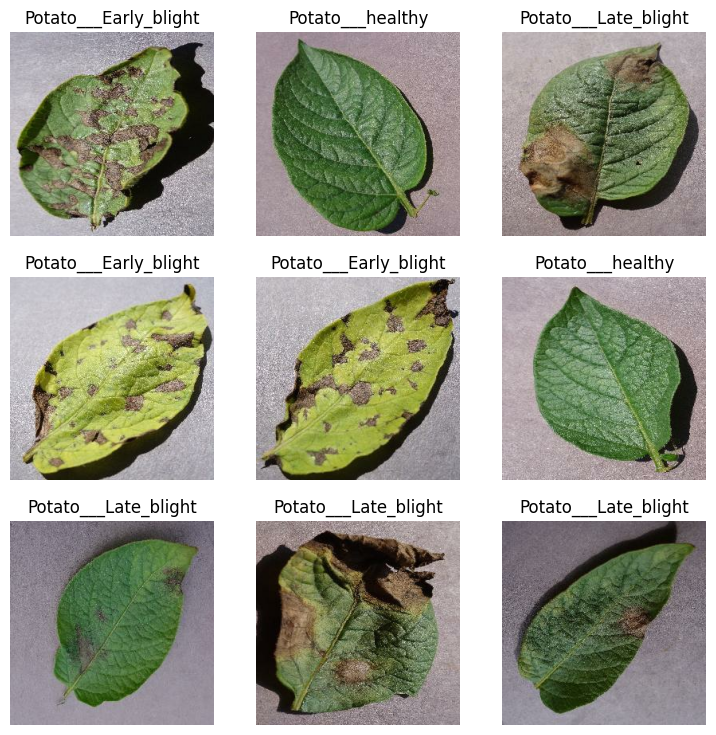

In [63]:
plt.figure(figsize = (9,9))
for image, label in dataset.take(1):
    
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.title(class_names[label[i]])
        plt.axis("off")
        plt.imshow(image[i].numpy().astype('uint8'))

### Train Test Split of the dataset

- We take 80% data as Train dataset
- 10% is for testing and 10% is for validation.

In [64]:
len(dataset)

68

In [65]:
train_size = int(len(dataset) * 0.8)
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
len(train_ds)

54

In [66]:
len_test_ds = int(0.1*len(dataset))
validation_ds = test_ds.take(len_test_ds)
len(validation_ds)

6

In [67]:
test_ds = test_ds.skip(len_test_ds)
len(test_ds)

8

In [68]:
def generate_dataset_partitions(ds, train_split = 0.8, validation_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
    len_ds = len(ds)
    train_size = int(train_split * len_ds)
    val_size = int(validation_split * len_ds)
    test_size = int(test_split * len_ds)
    
    train_ds = ds.take(train_size)
    validation_split = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, validation_ds, test_ds

In [69]:
train_ds, validation_ds, test_ds = generate_dataset_partitions(dataset)

In [70]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Preprocessing
- Rescaling
- Resizing
- Data Augmentation(rotate, flip, contrast, zoom)

In [71]:
## Piping the preprocessing steps
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [72]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

### Model Training

In [74]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    ## Convultional layers
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),##32 is number of filters to be aplied on each image, (3,3) is the filter size
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')

]) 

In [75]:
model.build(input_shape = input_shape)

In [76]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [118]:
history = model.fit(
    train_ds, 
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose =True,
    validation_data = validation_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 604ms/step - accuracy: 0.9480 - loss: 0.1217 - val_accuracy: 0.8438 - val_loss: 0.3869
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 528ms/step - accuracy: 0.9382 - loss: 0.1682 - val_accuracy: 0.9583 - val_loss: 0.1274
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 543ms/step - accuracy: 0.9561 - loss: 0.1082 - val_accuracy: 0.9531 - val_loss: 0.1159
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 566ms/step - accuracy: 0.9542 - loss: 0.1248 - val_accuracy: 0.9323 - val_loss: 0.1640
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 612ms/step - accuracy: 0.9593 - loss: 0.1078 - val_accuracy: 0.9479 - val_loss: 0.1438
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 598ms/step - accuracy: 0.9553 - loss: 0.1291 - val_accuracy: 0.9323 - val_loss: 0.1818
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 589ms/step - accuracy: 0.9538 - loss: 0.1095 - val_accuracy: 0.9375 - val_loss: 0.1720
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 600ms/step - accuracy: 0.9639 - loss: 0.0962 - val_accu

First image to Predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Predicted image is:  Potato___Late_blight


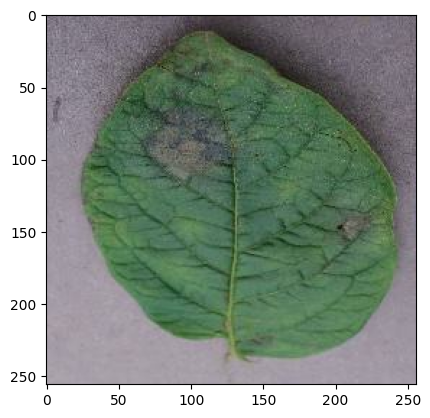

In [119]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to Predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Predicted image is: ", class_names[np.argmax(batch_prediction[0])])

In [120]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) ##Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


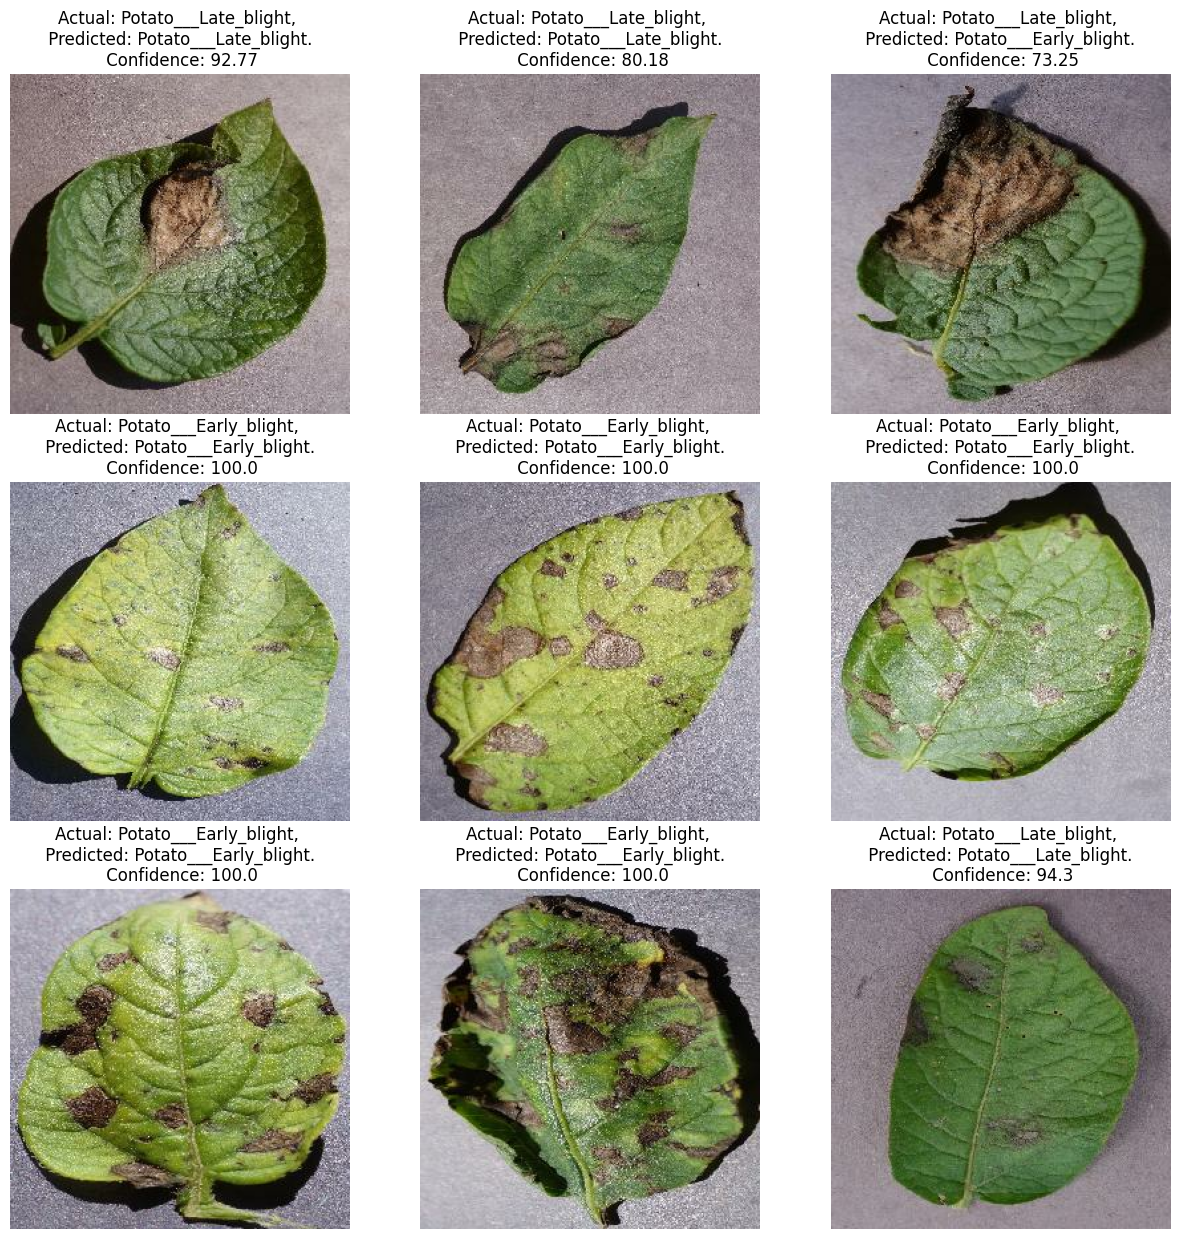

In [121]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1): ## Taking first Batch
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}")
        plt.axis("off")
        

### Save a model and auto-increment it whenever we save the model.

In [124]:
import os 
os.mkdir("models")

In [125]:
os.listdir()

['PlantVillage',
 '.DS_Store',
 'Potato-disease-classification.ipynb',
 'models',
 'README.md',
 '.gitignore',
 '.ipynb_checkpoints',
 '.git']

In [154]:
import os

# Get a list of model versions, filtering out any non-integer entries
model_versions = [
    int(i) for i in os.listdir("./models") 
    if i.isdigit()  # Filter out non-digit entries
]

# Determine the next model version
model_version = max(model_versions + [0]) + 1

# Create the directory if it doesn't exist
model_dir = f"models/{model_version}"
os.makedirs(model_dir, exist_ok=True)  # Create the directory

# Save the model
model.save(f"{model_dir}/model.keras")
